In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import fsspec, os
import scipy as sp
import PIL
from PIL import Image
import random
import os
import glob
import re

In [3]:
# Define shot lists and file paths
state = 1  # state 1 -> javier, state 2 -> william, state 3 -> combined
if state == 1:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769]
    file_path = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/Input Data/Shots/' 
    file_path_hbt = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/python_hbteplib_data/'
elif state == 2:
    shot_list = [114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
                 114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
                 114462,114464,114467,114468,114472,114473]
    file_path = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/Input Data/Old Shots/' 
    file_path_hbt = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/' 
elif state == 3:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
             119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
             119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
             119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769,
             114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
             114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
             114462,114464,114467,114468,114472,114473]
    # For shots >= 119000, use Javier's paths
    # For shots < 119000, use William's paths
    def get_paths_for_shot(shot_num):
        if shot_num >= 119000:
            return ('/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/Input Data/Shots/',
                   '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/python_hbteplib_data/')
        else:
            return ('/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/Input Data/Old Shots/',
                   '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/')


TARGET_FRAME_COUNT = 800
CAMERA_DEPTH = 65535.0 # 2^16


In [4]:
# Helper functions for data processing
def determine_frame_ratio(num_frames, target_frames=TARGET_FRAME_COUNT):
    """
    Determines the frame ratio needed to downsample the data to target_frames.
    Returns the ratio and the actual number of frames after downsampling.
    """
    ratio = max(1, num_frames // target_frames)
    actual_frames = num_frames // ratio
    return ratio, actual_frames

def process_shot_data(folder_path, target_frame_count, max_pixel_value, state, shot_num=None):
    """
    Process a single shot's data with automatic frame rate handling.
    Returns: 2D data (32x32), cut 2D data (32x32), and flat data for the shot
    """
    tiff_files = sorted(glob.glob(os.path.join(folder_path, "*.tiff")))
    num_frames = len(tiff_files)
    
    if num_frames == 0:
        raise ValueError(f"No TIFF files found in {folder_path}")
    
    frame_ratio, actual_frames = determine_frame_ratio(num_frames, target_frame_count)
    
    # Initialize shot lists
    flat_shot = []
    shot_2d = []
    cut_shot = []
    
    # Process TIFF files with dynamic frame ratio
    for j, tiff_file in enumerate(tiff_files):
        if j % frame_ratio == 0 and len(shot_2d) < target_frame_count:
            try:
                im = Image.open(tiff_file)
                im = np.array(im, dtype=np.float32)
                im = im / max_pixel_value
                
                # Crop to 32x32 for consistency across all shots
                if state == 3 and shot_num is not None:
                    if shot_num >= 119000:  # Javier's data: 32x128 -> 32x32
                        cropped_im = im[:, 48:-48]  # Crop width only
                    else:  # William's data: 64x128 -> 32x32
                        cropped_im = im[:, 48:-48]  # Crop width to 64x32
                        cropped_im = cropped_im[16:48, :]  # Crop height to 32x32
                elif state == 1:  # Javier's data: 32x128 -> 32x32
                    cropped_im = im[:, 48:-48]  # Crop width only
                elif state == 2:  # William's data: 64x128 -> 32x32
                    cropped_im = im[:, 48:-48]  # Crop width to 64x32
                    cropped_im = cropped_im[16:48, :]  # Crop height to 32x32
                
                flat_im = cropped_im.reshape(-1)  # Flatten the cropped image (32*32 = 1024)
                cut_2d = cropped_im  # cut_2d is the same as cropped_im (32x32)
                
                shot_2d.append(cropped_im)  # Store cropped image (32x32)
                flat_shot.append(flat_im)
                cut_shot.append(cut_2d)
                
            except Exception as e:
                print(f"Error loading {tiff_file}: {e}")
                continue
    
    return np.array(shot_2d), np.array(cut_shot), np.array(flat_shot)
    
def process_all_shots(shot_list, base_path, max_pixel_value, target_frame_count, state):
    """
    Process multiple shots with automatic frame rate handling
    """
    training_data_2D = []
    cut_training_data_2D = []
    flat_training_data = []
    
    for shot in shot_list:
        if state == 3:
            file_path, _ = get_paths_for_shot(shot)
            folder_path = os.path.join(file_path, str(shot), 'CAM-26731/tiff/')
        else:
            folder_path = os.path.join(base_path, str(shot), 'CAM-26731/tiff/')
        
        try:
            shot_2d, cut_2d, flat_data = process_shot_data(folder_path, target_frame_count, max_pixel_value, state, shot_num=shot)
            
            if len(shot_2d) == target_frame_count:
                training_data_2D.append(shot_2d)
                cut_training_data_2D.append(cut_2d)
                flat_training_data.append(flat_data)
            else:
                print(f"Shot {shot} produced {len(shot_2d)} frames, expected {target_frame_count}. Skipping.")
                
        except Exception as e:
            print(f"Error processing shot {shot}: {e}")
            continue
    
    return (np.array(training_data_2D), 
            np.array(cut_training_data_2D), 
            np.array(flat_training_data))

In [5]:
# Load and format HBT data
def format_hbt_data(data, mode_num):
    # Determine frame ratio
    original_length = data[0][0].shape[0] # 5000
    target_length = TARGET_FRAME_COUNT
    frame_ratio = original_length // target_length  # generally 5 (5000/TARGET_FRAME_COUNT)
    
    data = np.asarray(data, dtype=float)
    data = np.reshape(data[:,mode_num-1,:], (len(shot_list), original_length, 1))
    data = data[:,::frame_ratio,:]
    data = data[:,:target_length,:]
    return data

# Load HBT data
hbt_ma_data = []
hbt_mp_data = []
hbt_time_data = []
for i in range(len(shot_list)):
    shot = shot_list[i]
    # For state 3, determine the correct HBT path based on shot number
    if state == 3:
        _, file_path_hbt = get_paths_for_shot(shot)
        
    ma_list = []
    mp_list = []
    for j in range(1,5):
        ma_data = np.load(file_path_hbt+str(shot)+'m'+str(j)+'Amp.npy')
        mp_data = np.load(file_path_hbt+str(shot)+'m'+str(j)+'Phase.npy')
        ma_list.append(ma_data)
        mp_list.append(mp_data)
    
    hbt_ma_data.append(ma_list)
    hbt_mp_data.append(mp_list)
    time_data = np.load(file_path_hbt+str(shot)+'time.npy')
    hbt_time_data.append(time_data)

# Format HBT data
hbt_ma1_data = format_hbt_data(hbt_ma_data, 1)
hbt_ma2_data = format_hbt_data(hbt_ma_data, 2)
hbt_ma3_data = format_hbt_data(hbt_ma_data, 3)
hbt_ma4_data = format_hbt_data(hbt_ma_data, 4)

hbt_mp1_data = format_hbt_data(hbt_mp_data, 1)
hbt_mp2_data = format_hbt_data(hbt_mp_data, 2)
hbt_mp3_data = format_hbt_data(hbt_mp_data, 3)
hbt_mp4_data = format_hbt_data(hbt_mp_data, 4)

# Format time data
hbt_time_data = np.asarray(hbt_time_data, dtype=float)
hbt_time_data = np.reshape(hbt_time_data, (len(shot_list), hbt_ma_data[0][0].shape[0]))
original_length = hbt_time_data.shape[1]
frame_ratio = original_length // TARGET_FRAME_COUNT
hbt_time_data = hbt_time_data[:,::frame_ratio]
hbt_time_data = hbt_time_data[:,:TARGET_FRAME_COUNT]

print("HBT data shapes:")
print(f"Mode amplitude 1: {hbt_ma1_data.shape}")
print(f"Mode phase 1: {hbt_mp1_data.shape}")
print(f"Time data: {hbt_time_data.shape}")


# Process shot list
if state == 3:
    training_data_2D, cut_training_data_2D, flat_training_data = process_all_shots(shot_list, None, CAMERA_DEPTH, TARGET_FRAME_COUNT, 3)
else:
    training_data_2D, cut_training_data_2D, flat_training_data = process_all_shots(shot_list, file_path, CAMERA_DEPTH, TARGET_FRAME_COUNT, state)
    
print(f"training_data_2D shape: {training_data_2D.shape}")
print(f"cut_training_data_2D shape: {cut_training_data_2D.shape}")

HBT data shapes:
Mode amplitude 1: (37, 800, 1)
Mode phase 1: (37, 800, 1)
Time data: (37, 800)
training_data_2D shape: (37, 800, 32, 32)
cut_training_data_2D shape: (37, 800, 32, 32)


Training shape:  (29400, 32, 32) Target shape:  (29400, 1)
Testing shape:  (200, 32, 32) Testing label shape:  (200, 1)


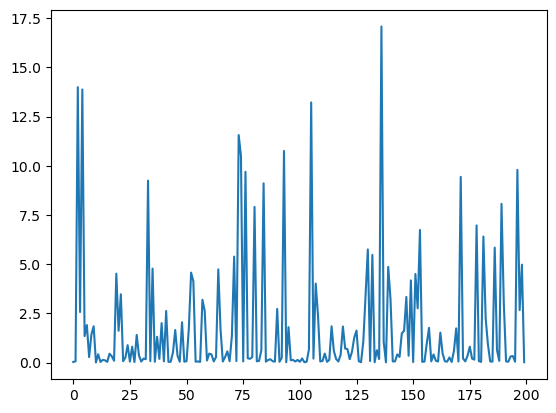

In [6]:
# Prepare data for HBT prediction model
target_data = hbt_ma2_data  # Using mode 2 amplitude as target
training_data = cut_training_data_2D

# Normalization factors
camera_norm = 1  # Camera data already normalized by max_pixel_value
ma_norm = 1  # Mode amplitude normalization factor

# Reshape the training data and labels
target_vector = []
training_vector = []
tot_frames = TARGET_FRAME_COUNT

for i in range(len(shot_list)):
    for j in range(len(target_data[i])):
        target_vector.append(target_data[i][j])
        training_vector.append(training_data[i][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(target_vector, training_vector))
random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)

# Convert to numpy arrays and normalize
target_vector = np.asarray(target_vector, dtype=np.float32) / ma_norm
training_vector = np.asarray(training_vector, dtype=np.float32)

# Split into training and testing sets
testing_inputs = training_vector[-201:-1]
testing_labels = target_vector[-201:-1]
training_vector = training_vector[0:-200]
target_vector = target_vector[0:-200]

print('Training shape: ', training_vector.shape, 'Target shape: ', target_vector.shape)
print('Testing shape: ', testing_inputs.shape, 'Testing label shape: ', testing_labels.shape)
plt.plot(testing_labels)

In [7]:
%%script true # This command stops it from running when pressing run all.
# DON'T RUN!! Single Shot. Prepare data for HBT prediction model
target_data = hbt_ma2_data  # Using mode 2 amplitude as target
training_data = cut_training_data_2D

# Normalization factors
camera_norm = 1  # Camera data already normalized by max_pixel_value
ma_norm = 1  # Mode amplitude normalization factor

# Reshape the training data and labels
target_vector = []
training_vector = []
shot = shot_list[-1]  # Select only the last shot
shot_idx = shot_list.index(shot)
for j in range(len(target_data[shot_idx])):  # Use frame count for the last shot
    target_vector.append(target_data[shot_idx][j])
    training_vector.append(training_data[-1][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(target_vector, training_vector))
#random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)

# Convert to numpy arrays and normalize
target_vector = np.asarray(target_vector, dtype=np.float32) / ma_norm
training_vector = np.asarray(training_vector, dtype=np.float32)

# Split into training and testing sets
testing_inputs = training_vector[-201:-1]
testing_labels = target_vector[-201:-1]
training_vector = training_vector[0:-200]
target_vector = target_vector[0:-200]

print('Training shape: ', training_vector.shape, 'Target shape: ', target_vector.shape)
print('Testing shape: ', testing_inputs.shape, 'Testing label shape: ', testing_labels.shape)

# Plot testing labels for the last shot
plt.plot(testing_labels)
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title(f'Testing Labels for Shot {shot}')
plt.grid(True)
plt.show()

In [8]:
# Define model architecture
num_conv2d_layers = 2
num_dense_layers = 1

conv2d_neurons = [16, 16]
conv2d_size = [(8, 8), (8, 8)]
dense_layer_neurons = [10]
max_pooling_size = (4, 4)
activation_func = 'relu'
loss_func = 'mean_squared_error'
optimizer_func = 'adam'

# Create the model
william_model = tf.keras.models.Sequential()

# Add input layer
william_model.add(tf.keras.layers.InputLayer(shape=(32, 32, 1)))

# Add Conv2D layers
for i in range(num_conv2d_layers):
    william_model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], 1, activation=activation_func))
    william_model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, 1))

# Flatten the output
william_model.add(tf.keras.layers.Flatten())

# Add dense layers
for i in range(num_dense_layers):
    william_model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))

# Output layer
william_model.add(tf.keras.layers.Dense(1))

# Compile the model
william_model.compile(optimizer=optimizer_func, loss=loss_func)

# Display model summary
william_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 15, 16)     │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        23,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,501 (158.21 KB)

 Trainable params: 40,501 (158.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
Model = william_model
history = Model.fit(training_vector, target_vector,
                       epochs=15,
                       validation_split=0.2,
                       verbose=1,
                       callbacks=[early_stop])

Epoch 1/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 7.7126 - val_loss: 5.6457
Epoch 2/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 6.1190 - val_loss: 5.1936
Epoch 3/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 5.5644 - val_loss: 4.9951
Epoch 4/15
114/735 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.3403

In [ ]:
# Evaluate the model on test data
predictions = Model.predict(testing_inputs)

# Calculate prediction errors
prediction_errors = abs((testing_labels[:,0]/np.max(testing_labels[:,0]) - 
                        predictions[:,0]/np.max(predictions[:,0]))) * 100

# Create visualization plots
fig, axes = plt.subplots(figsize=(15,5), ncols=3, nrows=1)

# Plot 1: Training History
axes[0].plot(range(1,len(history.history['val_loss'])+1), 
             history.history['val_loss'], 
             label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('HBT Model Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Error Distribution
weights = np.ones_like(prediction_errors) / len(prediction_errors) * 100
axes[1].hist(prediction_errors, 20, weights=weights)
axes[1].set_xlabel('% error')
axes[1].set_ylabel('% Count')
axes[1].set_title('Normalized Testing Error (n=200)')

# Plot 3: Error by Sample
axes[2].plot(prediction_errors, '.')
axes[2].set_xlabel('Test Sample Number')
axes[2].set_ylabel('% error')
axes[2].set_title('Normalized Testing Error')

plt.tight_layout()
plt.show()

# Plot 4: actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(testing_labels[:,0]/np.max(testing_labels[:,0]), '.', label='Actual Mode Amplitude')
plt.plot(predictions[:,0]/np.max(predictions[:,0]), '.', label='Predicted Mode Amplitude')
plt.plot(-(testing_labels[:,0]/np.max(testing_labels[:,0]) - 
           predictions[:,0]/np.max(predictions[:,0])), '*', label='Difference')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('HBT Mode Amplitude Prediction Results')
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum actual mode amplitude: {np.max(testing_labels[:,0])}")
print(f"Maximum predicted mode amplitude: {np.max(predictions[:,0])}")
print(f"Mean absolute percentage error: {np.mean(prediction_errors):.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(testing_labels * ma_norm, '.', label='Actual Mode Amplitude')
plt.plot(predictions * ma_norm, '.', label='Predicted Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Mode Amplitude (Original Scale)')
plt.title('HBT Mode Amplitude Prediction Results')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# YOU MUST change name before saving!!!
#Model.save_weights('Potential Models/model_agb001.weights.h5')